In [11]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
from openml import datasets, tasks, flows, config

#from openmlstudy14.preprocessing import ConditionalImputer
#from workloadoptimization.essentials import Component
#from workloadoptimization.essentials import ExperimentGraph, ExperimentParser
#from workloadoptimization.hyperopt_helper import TrialConverter
#from workloadoptimization.openml_helper import OpenMLReader
#from workloadoptimization.search_space import SearchSpaceDesigner
% matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))


In [12]:
# Constants 
LOGISTIC_REGRESSION_FLOW = 5981
RANDOM_FOREST_1_FLOW = 8568
RANDOM_FOREST_2_FLOW = 8315
SVC_1_FLOW = 8353
SVC_2_FLOW = 7707
CREDIT_G_DATASET = 31
FLOW_IDS = [LOGISTIC_REGRESSION_FLOW, RANDOM_FOREST_1_FLOW, RANDOM_FOREST_2_FLOW, SVC_1_FLOW, SVC_2_FLOW]

In [13]:
# load the dataset
task = tasks.get_task(task_id=CREDIT_G_DATASET)
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices, test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute,
    return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [14]:
def extract_experiments(file_path, task_ids, flow_ids):
    openMLReader = OpenMLReader()
    if os.path.isfile(file_path):
        return pd.read_pickle(file_path)
    frames = []
    for t in task_ids:
        for f in flow_ids:
            frames.append(openMLReader.getTopRuns(-1, f, t))
    experiments = pd.concat(frames).reset_index(drop=True)
    experiments.to_pickle(file_path)
    return experiments


# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extract_experiments('meta/database-experiment-reuse-openml', [CREDIT_G_DATASET], FLOW_IDS)

NameError: global name 'OpenMLReader' is not defined

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([('dualimputer', ConditionalImputer()),
                        ('standardscaler', StandardScaler()),
                        ('logisticregression', LogisticRegression())])


flow = flows.get_flow(flow_id=7707)
flow.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
for v in flow.components.itervalues():
    v.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
pipeline_svc_2 = flows.flow_to_sklearn(flow)

flow = flows.get_flow(flow_id=8568)
flow.components['conditionalimputer'].class_name = 'hyperimp.utils.preprocessing.ConditionalImputer2'
pipeline_rf_1 = flows.flow_to_sklearn(flow)

NameError: name 'ConditionalImputer' is not defined

In [6]:
# The openml api is not backward compatible for this specific pipeline (5981), so we are recreating it in scikit learn
OPENML_FLOWS = {LOGISTIC_REGRESSION_FLOW: pipeline_lr}
parser = ExperimentParser()
experimentObjects = parser.extract_sklearn_pipelines(
    Experiments[Experiments.flow_id.isin([LOGISTIC_REGRESSION_FLOW])], OPENML_FLOWS)
other_pipelines = {
    RANDOM_FOREST_1_FLOW: flows.get_flow(RANDOM_FOREST_1_FLOW),
    RANDOM_FOREST_2_FLOW: flows.get_flow(RANDOM_FOREST_2_FLOW),
    SVC_1_FLOW: flows.get_flow(SVC_1_FLOW),
    SVC_2_FLOW: flows.get_flow(SVC_2_FLOW)}
experimentObjects = experimentObjects + parser.extract_openml_flows(
    Experiments[Experiments.flow_id.isin(other_pipelines.keys())], other_pipelines)

NameError: name 'pipeline_lr' is not defined

In [7]:
pipelines = {LOGISTIC_REGRESSION_FLOW: pipeline_lr,
             SVC_2_FLOW: pipeline_svc_2,
             RANDOM_FOREST_1_FLOW: pipeline_rf_1,
             RANDOM_FOREST_2_FLOW: flows.flow_to_sklearn(flows.get_flow(RANDOM_FOREST_2_FLOW)),
             SVC_1_FLOW: flows.flow_to_sklearn(flows.get_flow(SVC_1_FLOW))}

NameError: name 'pipeline_lr' is not defined

In [17]:
for ex in experimentObjects:
    ex.fix_order(pipelines[ex.flow])

In [25]:
import warnings
import ast
import time
import copy

warnings.filterwarnings('ignore')


def load_existing_profile(path):
    if os.path.isfile(path):
        read = open(path, 'r')
        content = read.read()
        read.close()
        return ast.literal_eval(content)
    else:
        return {}


training = X[train_indices]
label = y[train_indices]

run_profiles = load_existing_profile('meta/reuse-profiles.txt')

pipelinesCopy = copy.deepcopy(pipelines)

for k, v in pipelinesCopy.iteritems():
    for e in experimentObjects:
        if e.flow == k:
            v.set_params(**e.extractParams())
            break

for pipelineKey, p in pipelinesCopy.iteritems():
    transformed = training
    if pipelineKey not in run_profiles.keys():
        comp = []
        i = 0
        for k, c in p.steps:
            is_transformation = getattr(c, "fit_transform", 'no')
            start = time.time()
            if is_transformation == 'no':
                c.fit(transformed, label)
            else:
                isSparse = getattr(transformed, "todense", False)
                if isSparse:
                    transformed = transformed.todense()
                transformed = c.fit_transform(transformed, label)
            end = time.time()
            comp.append(end - start)
            i = i + 1
        run_profiles[pipelineKey] = comp

# Write the profiles back to file
target = open('meta/reuse-profiles.txt', 'w')
target.write(str(run_profiles))
target.close()


In [26]:
for ex in experimentObjects:
    runProfile = run_profiles[ex.flow]
    total = 0
    for i in range(len(runProfile)):
        total = total + runProfile[i]
        ex.components[i].estimatedRunTime = runProfile[i]
    ex.estimatedRunTime = total

In [27]:
experimentGraph = ExperimentGraph()
for ex in experimentObjects:
    experimentGraph.insertExperimentObject(ex)


In [103]:
# Visualize the Graph
def draw_graph(graph):
    def pretty_label(edge_label):
        if edge_label['weight'] <= 1:
            return ''
        else:
            return '{} , ({})'.format(edge_label['name'], edge_label['weight'])
    edge_labels = dict([((u, v,), pretty_label(d)) for u, v, d in graph.edges(data=True)])
    labels = dict({k for k in graph.nodes(data='label')})
    pos = graphviz_layout(graph, prog='dot')
    gp = plt.figure(figsize=(20, 20))
    nx.draw_networkx_edge_labels(graph, pos, alpha=1, edge_labels=edge_labels, font_size=12)
    nx.draw_networkx_nodes(graph, pos, node_size=200)
    nx.draw_networkx_edges(graph, pos, alpha=1, arrows=True)
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=16)
    gp.savefig("graph.png")


draw_graph(experimentGraph.graph)


In [28]:
# Start with a fresh graph
realGraph = ExperimentGraph()

In [29]:
from random import shuffle

# unoptimizedTime = []
# optimizedTime = []
# unoptimizedSteps = []
# optimizedSteps = []
pipeline_times = {}
# Shuffle the objects to indicate we have no knowledge of the order of the incoming pipelines
shuffledList = list(experimentObjects)
# shuffle(shuffledList)
for ex in shuffledList:
    # executes the object using the graph and returns the following: prefix: is the common path for the incoming 
    # pipeline and the existing graph, this indicates which components of the pipelie can be skipped 
    # optimizedTime; The execution time after optimizing the pipeline 
    prefix, steps, optimizedTime = realGraph.optimizeAndRun(ex)
    # print steps, optimizedTime
    if ex.flow in pipeline_times.keys():
        (a, b, c, d) = pipeline_times[ex.flow]
        # print a,b,c,d
        pipeline_times[ex.flow] = (optimizedTime + a, ex.defaultRunTime() + b, steps + c, len(ex.components) + d)
    else:
        pipeline_times[ex.flow] = (optimizedTime, ex.defaultRunTime(), steps, len(ex.components))
    # unoptimizedTime.append(ex.defaultRunTime())
    # optimizedTime.append(optimizedTime)
    # unoptimizedSteps.append(len(ex.components))
    # optimizedSteps.append(steps)


In [37]:
tempList = []
for k, v in pipeline_times.iteritems():
    tempList.append((k, v[0], v[1], v[2], v[3]))
results = pd.DataFrame.from_records(tempList,
                                    columns=['pipeline', 'time_optimized', 'time_unoptimized', 'steps_optimized',
                                             'steps_unoptimized'])


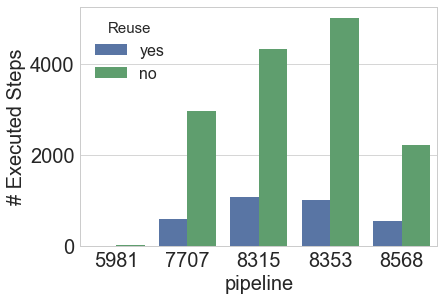

In [57]:
step_melted = pd.melt(results[['pipeline', 'steps_optimized', 'steps_unoptimized']]
                      .rename(index=str, columns={'steps_optimized': 'yes', 'steps_unoptimized': 'no'}),
                      id_vars='pipeline', var_name='Reuse')
ax = sns.barplot(data=step_melted, x='pipeline', y='value', hue='Reuse')
ax.set_ylabel('# Executed Steps', fontsize=20)
ax.set_xlabel('pipeline', fontsize=20)
ax.tick_params(labelsize=20)
plt.savefig('figures/paper/reuse-openml-steps.eps', format='eps', dpi=1000, bbox_inches='tight')


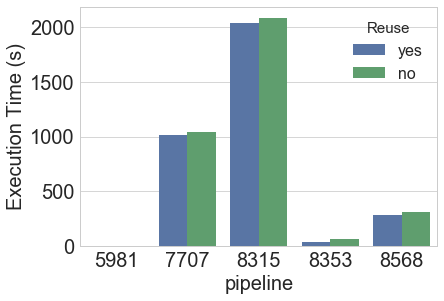

In [59]:
time_melted = pd.melt(results[['pipeline', 'time_optimized', 'time_unoptimized']]
                      .rename(index=str, columns={'time_optimized': 'yes', 'time_unoptimized': 'no'}),
                      id_vars='pipeline', var_name='Reuse')
ax = sns.barplot(data=time_melted, x='pipeline', y='value', hue='Reuse')
ax.set_ylabel('Execution Time (s)', fontsize=20)
ax.set_xlabel('pipeline', fontsize=20)
ax.tick_params(labelsize=20)
plt.savefig('figures/paper/reuse-openml-time.eps', format='eps', dpi=1000, bbox_inches='tight')